<a href="https://colab.research.google.com/github/IlyaTsibulin/-/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install thop
!pip install seaborn
!pip install wandb
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def select_subset(dataset, num_per_class):
    indices = []
    class_counts = [0] * len(dataset.classes)
    for i, (_, label) in enumerate(dataset):
        if class_counts[label] < num_per_class:
            indices.append(i)
            class_counts[label] += 1
        if sum(class_counts) >= num_per_class * len(dataset.classes):
            break
    subset = torch.utils.data.Subset(dataset, indices)
    return subset

trainset = select_subset(full_trainset, 100)
testset = select_subset(full_testset, 20)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn

class YOLOv9Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(YOLOv9Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = YOLOv9Classifier()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Обучение завершено')

Обучение завершено


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 200 test images: {100 * correct / total}%')


Accuracy of the network on the 200 test images: 29.0%


In [ ]:
!pip install torch torchvision matplotlib
!pip install thop
!pip install seaborn
!pip install wandb
!pip install opencv-python

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def select_subset(dataset, num_per_class):
    indices = []
    class_counts = [0] * len(dataset.classes)
    for i, (_, label) in enumerate(dataset):
        if class_counts[label] < num_per_class:
            indices.append(i)
            class_counts[label] += 1
        if sum(class_counts) >= num_per_class * len(dataset.classes):
            break
    subset = torch.utils.data.Subset(dataset, indices)
    return subset

trainset = select_subset(full_trainset, 200)
testset = select_subset(full_testset, 50)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:03<00:00, 48504298.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch.nn as nn

class YOLOv9Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(YOLOv9Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = YOLOv9Classifier()


[Epoch 1, Batch 10] loss: 2.221
[Epoch 1, Batch 20] loss: 2.388
[Epoch 1, Batch 30] loss: 2.332
[Epoch 1, Batch 40] loss: 1.990
[Epoch 1, Batch 50] loss: 1.954
[Epoch 1, Batch 60] loss: 1.943
[Epoch 2, Batch 10] loss: 1.816
[Epoch 2, Batch 20] loss: 1.681
[Epoch 2, Batch 30] loss: 1.696
[Epoch 2, Batch 40] loss: 1.657
[Epoch 2, Batch 50] loss: 1.570
[Epoch 2, Batch 60] loss: 1.708
[Epoch 3, Batch 10] loss: 1.475
[Epoch 3, Batch 20] loss: 1.488
[Epoch 3, Batch 30] loss: 1.530
[Epoch 3, Batch 40] loss: 1.570
[Epoch 3, Batch 50] loss: 1.654
[Epoch 3, Batch 60] loss: 1.612
[Epoch 4, Batch 10] loss: 1.391
[Epoch 4, Batch 20] loss: 1.368
[Epoch 4, Batch 30] loss: 1.389
[Epoch 4, Batch 40] loss: 1.461
[Epoch 4, Batch 50] loss: 1.363
[Epoch 4, Batch 60] loss: 1.501
[Epoch 5, Batch 10] loss: 1.246
[Epoch 5, Batch 20] loss: 1.348
[Epoch 5, Batch 30] loss: 1.307
[Epoch 5, Batch 40] loss: 1.377
[Epoch 5, Batch 50] loss: 1.303
[Epoch 5, Batch 60] loss: 1.356
Обучение завершено


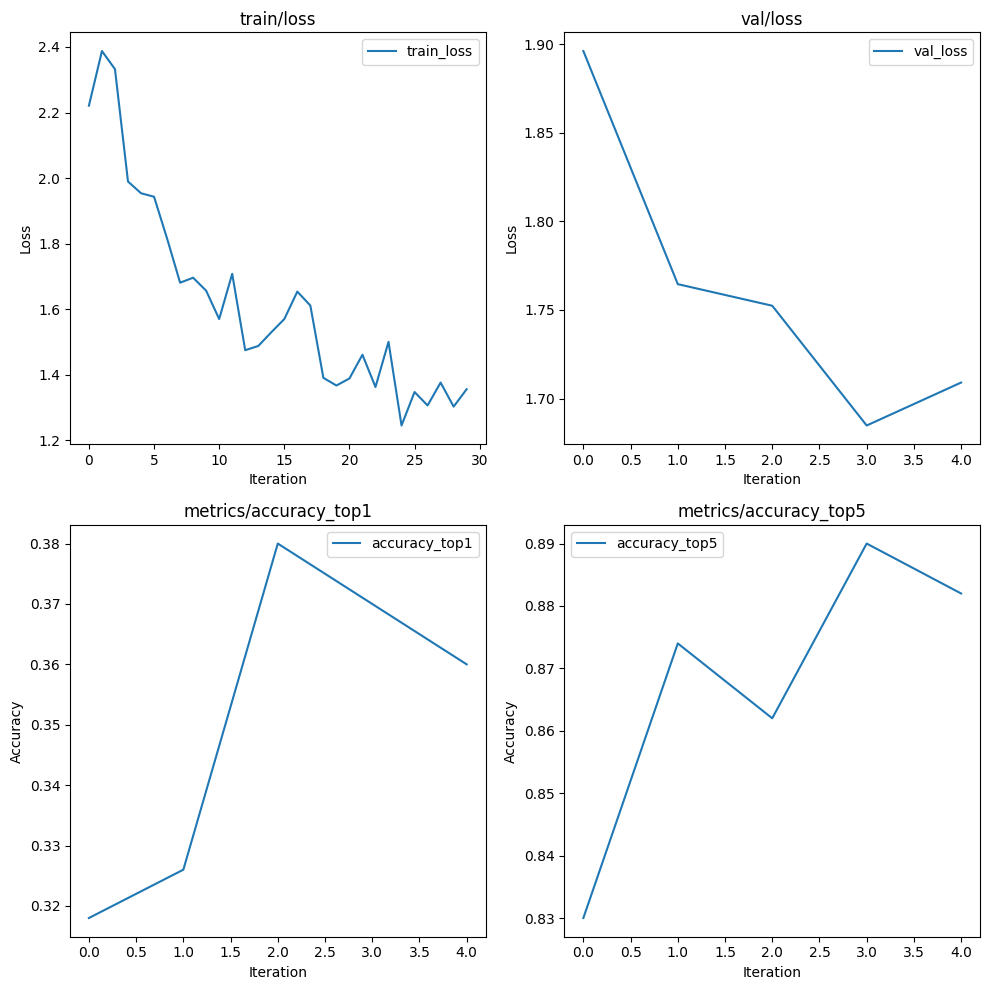

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_losses = []
val_losses = []
accuracy_top1 = []
accuracy_top5 = []

def calculate_accuracy(loader, model):
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            correct_top1 += (predicted[:, 0] == labels).sum().item()
            correct_top5 += (predicted == labels.view(-1, 1)).sum().item()
    return correct_top1 / total, correct_top5 / total

for epoch in range(5):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.3f}')
            train_losses.append(running_loss / 10)
            running_loss = 0.0

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(testloader))

    acc_top1, acc_top5 = calculate_accuracy(testloader, model)
    accuracy_top1.append(acc_top1)
    accuracy_top5.append(acc_top5)

print('Обучение завершено')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(train_losses, label='train_loss')
axs[0, 0].set_title('train/loss')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Loss')

axs[0, 1].plot(val_losses, label='val_loss')
axs[0, 1].set_title('val/loss')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Loss')

axs[1, 0].plot(accuracy_top1, label='accuracy_top1')
axs[1, 0].set_title('metrics/accuracy_top1')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Accuracy')

axs[1, 1].plot(accuracy_top5, label='accuracy_top5')
axs[1, 1].set_title('metrics/accuracy_top5')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Accuracy')

for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
!pip install torch torchvision matplotlib
!pip install thop
!pip install wandb
!pip install opencv-python


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.optim as optim

class YOLOv9Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(YOLOv9Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = YOLOv9Classifier()


In [ ]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_losses = []
val_losses = []
accuracy_top1 = []
accuracy_top5 = []

def calculate_accuracy(loader, model):
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            correct_top1 += (predicted[:, 0] == labels).sum().item()
            correct_top5 += (predicted == labels.view(-1, 1)).sum().item()
    return correct_top1 / total, correct_top5 / total

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.3f}')
            train_losses.append(running_loss / 10)
            running_loss = 0.0
    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(testloader))

    acc_top1, acc_top5 = calculate_accuracy(testloader, model)
    accuracy_top1.append(acc_top1)
    accuracy_top5.append(acc_top5)

print('Обучение завершено')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(train_losses, label='train_loss')
axs[0, 0].set_title('train/loss')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Loss')

axs[0, 1].plot(val_losses, label='val_loss')
axs[0, 1].set_title('val/loss')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Loss')

axs[1, 0].plot(accuracy_top1, label='accuracy_top1')
axs[1, 0].set_title('metrics/accuracy_top1')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Accuracy')

axs[1, 1].plot(accuracy_top5, label='accuracy_top5')
axs[1, 1].set_title('metrics/accuracy_top5')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Accuracy')

for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()


[Epoch 1, Batch 10] loss: 2.991
[Epoch 1, Batch 20] loss: 2.078
[Epoch 1, Batch 30] loss: 2.042
[Epoch 1, Batch 40] loss: 1.996
[Epoch 1, Batch 50] loss: 1.998
[Epoch 1, Batch 60] loss: 1.991
[Epoch 1, Batch 70] loss: 2.012
[Epoch 1, Batch 80] loss: 2.005
[Epoch 1, Batch 90] loss: 2.036
[Epoch 1, Batch 100] loss: 2.022
[Epoch 1, Batch 110] loss: 2.069
[Epoch 1, Batch 120] loss: 2.002
[Epoch 1, Batch 130] loss: 2.078
[Epoch 1, Batch 140] loss: 1.975
[Epoch 1, Batch 150] loss: 2.046
[Epoch 1, Batch 160] loss: 2.120
[Epoch 1, Batch 170] loss: 2.049
[Epoch 1, Batch 180] loss: 2.061
[Epoch 1, Batch 190] loss: 2.052
[Epoch 1, Batch 200] loss: 2.030
[Epoch 1, Batch 210] loss: 2.051
[Epoch 1, Batch 220] loss: 2.061
[Epoch 1, Batch 230] loss: 2.005
[Epoch 1, Batch 240] loss: 2.016
[Epoch 1, Batch 250] loss: 2.070
[Epoch 1, Batch 260] loss: 2.061
[Epoch 1, Batch 270] loss: 2.043
[Epoch 1, Batch 280] loss: 2.113
[Epoch 1, Batch 290] loss: 2.082
[Epoch 1, Batch 300] loss: 2.064
[Epoch 1, Batch 310

In [ ]:
!pip install torch torchvision matplotlib
!pip install thop
!pip install wandb
!pip install opencv-python


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class FilteredCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, download=False):
        super().__init__(root, train=train, transform=transform, download=download)
        self.data, self.targets = self._filter_classes(self.data, self.targets)

    def _filter_classes(self, data, targets):
        data_filtered = []
        targets_filtered = []
        for i, target in enumerate(targets):
            if target in [0, 1]:
                data_filtered.append(data[i])
                targets_filtered.append(target)
        return data_filtered, targets_filtered

trainset = FilteredCIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = FilteredCIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car')

print(f"Number of training samples: {len(trainset)}")
print(f"Number of testing samples: {len(testset)}")


Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 10000
Number of testing samples: 2000


In [ ]:
class YOLOv9Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(YOLOv9Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = YOLOv9Classifier()


In [ ]:
import torch.nn as nn

class YOLOv9Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(YOLOv9Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = YOLOv9Classifier()


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_losses = []
val_losses = []
accuracy_top1 = []
accuracy_top5 = []

def calculate_accuracy(loader, model):
    correct_top1 = 0
    correct_top5 = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            correct_top1 += (predicted[:, 0] == labels).sum().item()
            correct_top5 += (predicted == labels.view(-1, 1)).sum().item()
    return correct_top1 / total, correct_top5 / total

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.3f}')
            train_losses.append(running_loss / 10)
            running_loss = 0.0
    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(testloader))

    acc_top1, acc_top5 = calculate_accuracy(testloader, model)
    accuracy_top1.append(acc_top1)
    accuracy_top5.append(acc_top5)

print('Обучение завершено')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(train_losses, label='train_loss')
axs[0, 0].set_title('train/loss')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Loss')

axs[0, 1].plot(val_losses, label='val_loss')
axs[0, 1].set_title('val/loss')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Loss')

axs[1, 0].plot(accuracy_top1, label='accuracy_top1')
axs[1, 0].set_title('metrics/accuracy_top1')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Accuracy')

axs[1, 1].plot(accuracy_top5, label='accuracy_top5')
axs[1, 1].set_title('metrics/accuracy_top5')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Accuracy')

for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()


[Epoch 1, Batch 10] loss: 2.192
[Epoch 1, Batch 20] loss: 0.741
[Epoch 1, Batch 30] loss: 0.737
[Epoch 1, Batch 40] loss: 0.686
[Epoch 1, Batch 50] loss: 0.650
[Epoch 1, Batch 60] loss: 0.626
[Epoch 1, Batch 70] loss: 0.598
[Epoch 1, Batch 80] loss: 0.730
[Epoch 1, Batch 90] loss: 0.660
[Epoch 1, Batch 100] loss: 0.710
[Epoch 1, Batch 110] loss: 0.669
[Epoch 1, Batch 120] loss: 0.662
[Epoch 1, Batch 130] loss: 0.696
[Epoch 1, Batch 140] loss: 0.696
[Epoch 1, Batch 150] loss: 0.692
[Epoch 1, Batch 160] loss: 0.678
[Epoch 1, Batch 170] loss: 0.687
[Epoch 1, Batch 180] loss: 0.672
[Epoch 1, Batch 190] loss: 0.668
[Epoch 1, Batch 200] loss: 0.667
[Epoch 1, Batch 210] loss: 0.654
[Epoch 1, Batch 220] loss: 0.675
[Epoch 1, Batch 230] loss: 0.676
[Epoch 1, Batch 240] loss: 0.623
[Epoch 1, Batch 250] loss: 0.642
[Epoch 1, Batch 260] loss: 0.647
[Epoch 1, Batch 270] loss: 0.694
[Epoch 1, Batch 280] loss: 0.694
[Epoch 1, Batch 290] loss: 0.707
[Epoch 1, Batch 300] loss: 0.686
[Epoch 1, Batch 310

RuntimeError: selected index k out of range

In [ ]:
!pip install torch torchvision matplotlib
!pip install thop
!pip install wandb
!pip install opencv-python


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class FilteredCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, download=False):
        super().__init__(root, train=train, transform=transform, download=download)
        self.data, self.targets = self._filter_classes(self.data, self.targets)

    def _filter_classes(self, data, targets):
        data_filtered = []
        targets_filtered = []
        for i, target in enumerate(targets):
            if target in [0, 1]:
                data_filtered.append(data[i])
                targets_filtered.append(target)
        return np.array(data_filtered), torch.tensor(targets_filtered)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

trainset = FilteredCIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

testset = FilteredCIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

classes = ('plane', 'car')


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class YOLOv9Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(YOLOv9Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = YOLOv9Classifier()


[Epoch 1, Batch 10] loss: 1.172
[Epoch 1, Batch 20] loss: 1.221
[Epoch 1, Batch 30] loss: 2.388
[Epoch 1, Batch 40] loss: 1.481
[Epoch 1, Batch 50] loss: 0.628
[Epoch 1, Batch 60] loss: 0.586
[Epoch 1, Batch 70] loss: 0.588
[Epoch 1, Batch 80] loss: 0.665
[Epoch 1, Batch 90] loss: 0.549
[Epoch 1, Batch 100] loss: 0.586
[Epoch 1, Batch 110] loss: 0.620
[Epoch 1, Batch 120] loss: 0.614
[Epoch 1, Batch 130] loss: 0.535
[Epoch 1, Batch 140] loss: 0.624
[Epoch 1, Batch 150] loss: 0.530
[Epoch 1, Batch 160] loss: 0.611
[Epoch 1, Batch 170] loss: 0.532
[Epoch 1, Batch 180] loss: 0.644
[Epoch 1, Batch 190] loss: 0.678
[Epoch 1, Batch 200] loss: 0.580
[Epoch 1, Batch 210] loss: 0.547
[Epoch 1, Batch 220] loss: 0.610
[Epoch 1, Batch 230] loss: 0.605
[Epoch 1, Batch 240] loss: 0.585
[Epoch 1, Batch 250] loss: 0.540
[Epoch 1, Batch 260] loss: 0.588
[Epoch 1, Batch 270] loss: 0.553
[Epoch 1, Batch 280] loss: 0.517
[Epoch 1, Batch 290] loss: 0.556
[Epoch 1, Batch 300] loss: 0.533
[Epoch 1, Batch 310

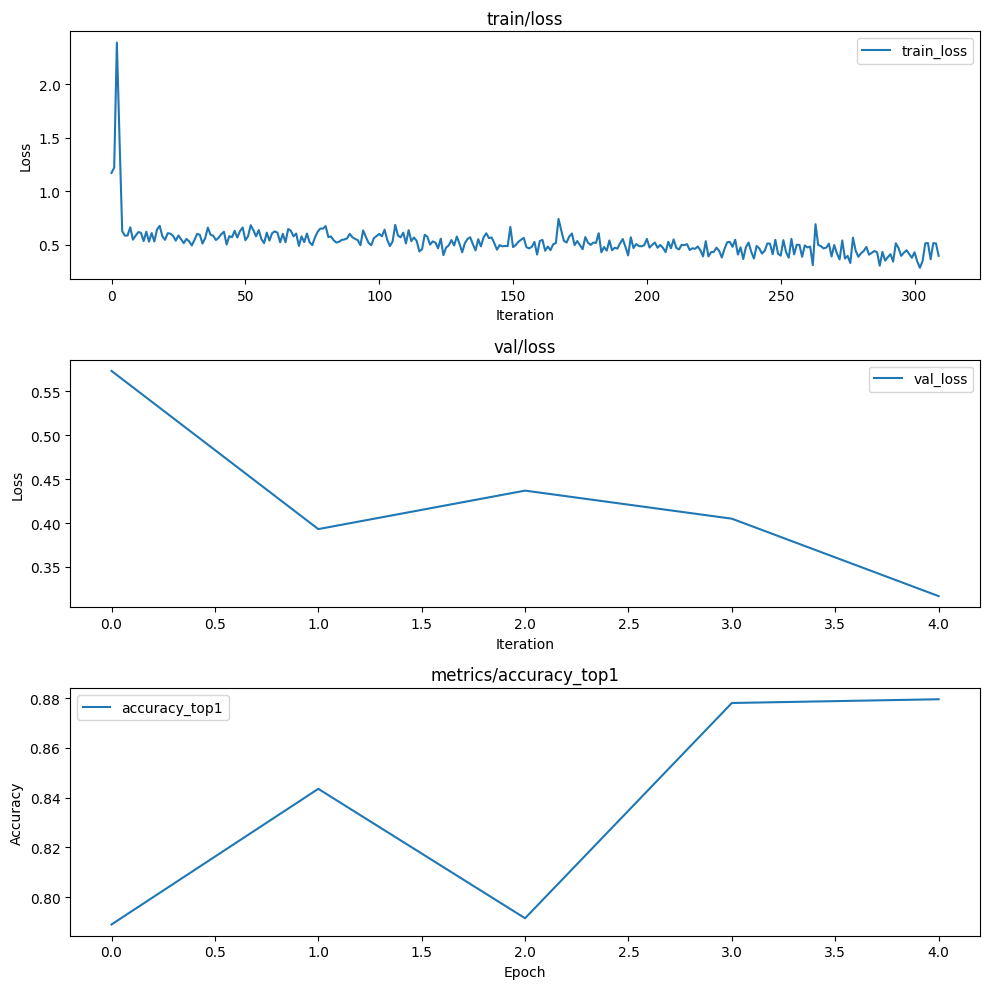

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = []
val_losses = []
accuracy_top1 = []

def calculate_accuracy(loader, model):
    correct_top1 = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct_top1 += (predicted == labels).sum().item()
    return correct_top1 / total

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.3f}')
            train_losses.append(running_loss / 10)
            running_loss = 0.0
    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(testloader))

    acc_top1 = calculate_accuracy(testloader, model)
    accuracy_top1.append(acc_top1)

print('Обучение завершено')

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='train_loss')
axs[0].set_title('train/loss')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')

axs[1].plot(val_losses, label='val_loss')
axs[1].set_title('val/loss')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')

axs[2].plot(accuracy_top1, label='accuracy_top1')
axs[2].set_title('metrics/accuracy_top1')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')

for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()
